Preprocessing images...


Processing train_images_without_YOLO: 100%|██████████| 1994/1994 [04:37<00:00,  7.20it/s]


Computing reconstruction errors...


Computing errors for processed_images: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Statistics:
Images above threshold: 1366/1991 (68.61%)
Images below threshold: 625/1991 (31.39%)
Mean error: 0.013324
Median error: 0.012203
Standard deviation: 0.006014
Plotting histogram...


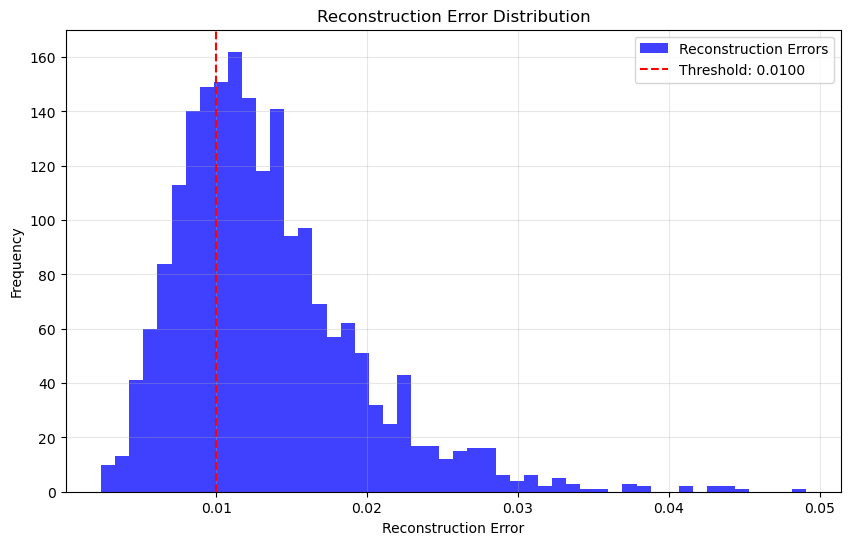

In [2]:
import torch
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from torch.utils.data import DataLoader
from autoencoder import DNIAnomalyDetector, DNIDataset
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_images_with_yolo(yolo_model, input_dir, output_dir):
    """
    Detect, crop, and ensure horizontal orientation of DNI images using YOLO.

    Args:
        yolo_model: YOLO model for detection.
        input_dir: Directory containing input images.
        output_dir: Directory to save processed images.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    image_paths = list(Path(input_dir).glob('*.jpg'))
    for img_path in tqdm(image_paths, desc=f"Processing {input_dir}"):
        try:
            results = yolo_model(str(img_path), verbose=False)[0]
            if not results.boxes:  # Skip if no detection
                continue

            # Get the best detection
            best_box = results.boxes[results.boxes.conf.argmax()]
            bbox = best_box.xyxy[0].cpu().numpy()
            cropped_image = crop_and_reorient_image(Image.open(img_path), bbox)

            # Save cropped image
            cropped_image.save(Path(output_dir) / img_path.name)
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")

def crop_and_reorient_image(image, bbox):
    """
    Crop and ensure the image is horizontal (width > height).

    Args:
        image: PIL Image to process.
        bbox: Bounding box [x1, y1, x2, y2].

    Returns:
        A cropped and correctly oriented PIL Image.
    """
    x1, y1, x2, y2 = map(int, bbox)
    cropped_image = image.crop((x1, y1, x2, y2))

    # Ensure horizontal orientation
    if cropped_image.height > cropped_image.width:
        cropped_image = cropped_image.rotate(90, expand=True)
    
    return cropped_image

def compute_reconstruction_errors(detector, data_dir, batch_size=32):
    """Compute reconstruction errors for images in a directory."""
    dataset = DNIDataset(data_dir, detector.transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    errors = []
    with torch.no_grad():
        for imgs in tqdm(loader, desc=f"Computing errors for {data_dir}"):
            imgs = imgs.to(detector.device)
            reconstructed = detector.decoder(detector.encoder(imgs))
            batch_errors = torch.nn.functional.mse_loss(
                reconstructed, imgs, reduction='none'
            ).mean(dim=[1, 2, 3]).cpu().numpy()
            errors.extend(batch_errors)

    return np.array(errors)

def process_single_model(yolo_model_path, autoencoder_model_path, input_dir, output_dir, batch_size=32):
    """
    Process images with YOLO, compute reconstruction errors using a single autoencoder model.

    Args:
        yolo_model_path: Path to YOLO model weights.
        autoencoder_model_path: Path to autoencoder model.
        input_dir: Directory containing input images.
        output_dir: Directory to save processed images.
        batch_size: Batch size for reconstruction error computation.
    """
    # Load YOLO model
    yolo_model = YOLO(yolo_model_path)

    # Load autoencoder model
    detector = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
    detector.load_model(autoencoder_model_path)

    # Preprocess images with YOLO
    print("Preprocessing images...")
    preprocess_images_with_yolo(yolo_model, input_dir, output_dir)

    # Compute reconstruction errors
    print("Computing reconstruction errors...")
    errors = compute_reconstruction_errors(detector, output_dir, batch_size)

    # Print statistics
    print_statistics(errors, detector.threshold)

def print_statistics(errors, threshold):
    """Print statistics for reconstruction errors."""
    above_threshold = np.sum(errors > threshold)
    below_threshold = np.sum(errors <= threshold)

    print(f"\nStatistics:")
    print(f"Images above threshold: {above_threshold}/{len(errors)} ({100 * above_threshold / len(errors):.2f}%)")
    print(f"Images below threshold: {below_threshold}/{len(errors)} ({100 * below_threshold / len(errors):.2f}%)")
    print(f"Mean error: {errors.mean():.6f}")
    print(f"Median error: {np.median(errors):.6f}")
    print(f"Standard deviation: {errors.std():.6f}")
    


    
    

def plot_histogram(errors, threshold):
    """
    Plot a histogram of reconstruction errors with a threshold line.

    Args:
        errors: Array of reconstruction errors.
        threshold: Threshold value for anomaly detection.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.75, color='blue', label='Reconstruction Errors')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def process_single_model(yolo_model_path, autoencoder_model_path, input_dir, output_dir, batch_size=32):
    """
    Process images with YOLO, compute reconstruction errors using a single autoencoder model.

    Args:
        yolo_model_path: Path to YOLO model weights.
        autoencoder_model_path: Path to autoencoder model.
        input_dir: Directory containing input images.
        output_dir: Directory to save processed images.
        batch_size: Batch size for reconstruction error computation.
    """
    # Load YOLO model
    yolo_model = YOLO(yolo_model_path)

    # Load autoencoder model
    detector = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
    detector.load_model(autoencoder_model_path)

    # Preprocess images with YOLO
    print("Preprocessing images...")
    preprocess_images_with_yolo(yolo_model, input_dir, output_dir)

    # Compute reconstruction errors
    print("Computing reconstruction errors...")
    errors = compute_reconstruction_errors(detector, output_dir, batch_size)

    # Print statistics
    print_statistics(errors, detector.threshold)

    # Plot histogram
    print("Plotting histogram...")
    plot_histogram(errors, detector.threshold)

# Example usage
if __name__ == "__main__":
    process_single_model(
        yolo_model_path="api/best.pt",
        autoencoder_model_path="models/dni_anomaly_detector.pt",
        input_dir="autoencoder_data/train_images_without_YOLO",
        output_dir="processed_images",
        batch_size=32
    )




In [5]:
detector = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
detector.load_model('dni_anomaly_detector_dorso.pt')

detector.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.3)
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
    ToTensor()
)